# Various examples with the Spectrum object

In [1]:
# Reload
import datetime

import matplotlib.pyplot as plt
import numpy as np
import tables

from becquerel import Spectrum, SpectrumError

%load_ext autoreload
%autoreload 2

np.random.seed(0)

## Basic properties

Let's load a spectrum from a file and look at some of its basic properties.

In [2]:
spec = Spectrum.from_file("../tests/samples/1110C NAA cave pottery.Spe")

SpeFile: Reading file ../tests/samples/1110C NAA cave pottery.Spe


How many channels?

In [3]:
len(spec)

16384

Did an energy calibration get loaded from the file?

In [4]:
spec.is_calibrated

True

When was this spectrum acquired? How long is it?

In [5]:
print(spec.start_time)
print(spec.stop_time)
print(spec.realtime)
print(spec.livetime)

2017-04-25 12:54:27
2017-04-25 17:30:24
16557.0
16543.0


Let's take a look at the counts in some of the bins.

In [6]:
spec.counts_vals[7980:8010]

array([ 7.,  9.,  3.,  4.,  6.,  8.,  2.,  7.,  8., 12.,  6.,  9., 13.,
       28., 22., 19., 14., 20., 13.,  9., 15.,  6.,  5.,  5.,  3.,  1.,
        2.,  1.,  0.,  0.])

What energy are those bins at?

In [7]:
spec.bin_centers_kev[7980:8010]

array([1458.78770768, 1458.97050062, 1459.15329356, 1459.3360865 ,
       1459.51887943, 1459.70167237, 1459.8844653 , 1460.06725823,
       1460.25005116, 1460.43284409, 1460.61563702, 1460.79842995,
       1460.98122287, 1461.1640158 , 1461.34680872, 1461.52960164,
       1461.71239456, 1461.89518748, 1462.07798039, 1462.26077331,
       1462.44356622, 1462.62635914, 1462.80915205, 1462.99194496,
       1463.17473787, 1463.35753078, 1463.54032368, 1463.72311659,
       1463.90590949, 1464.08870239])

## Uncertainties, CPS, coarser binning

The counts include uncertainty by default.

In [8]:
print(f"counts: {spec.counts[7990:7997]}")
print(f"counts_vals: {spec.counts_vals[7990:7997]}")
print(f"counts_uncs: {spec.counts_uncs[7990:7997]}")

counts: [6.0+/-2.449489742783178 9.0+/-3.0 13.0+/-3.605551275463989
 28.0+/-5.291502622129181 22.0+/-4.69041575982343 19.0+/-4.358898943540674
 14.0+/-3.7416573867739413]
counts_vals: [ 6.  9. 13. 28. 22. 19. 14.]
counts_uncs: [2.44948974 3.         3.60555128 5.29150262 4.69041576 4.35889894
 3.74165739]


We also have access to CPS, and CPS/keV, with their values and uncertainties.

In [9]:
print(f"cps:      {spec.cps[7990:7997]}")
print(f"cps_vals: {spec.cps_vals[7990:7997]}")
print(f"cps_uncs: {spec.cps_uncs[7990:7997]}")
print()
print(f"cpskev:   {spec.cpskev[7990:7997]}")

cps:      [0.00036269116847004775+/-0.00014806804949423792
 0.0005440367527050716+/-0.00018134558423502388
 0.0007858308650184368+/-0.0002179502675127842
 0.0016925587861935563+/-0.0003198635448303924
 0.0013298676177235084+/-0.00028352872875678106
 0.0011485220334884845+/-0.0002634890251792706
 0.0008462793930967781+/-0.0002261776816039377]
cps_vals: [0.00036269 0.00054404 0.00078583 0.00169256 0.00132987 0.00114852
 0.00084628]
cps_uncs: [0.00014807 0.00018135 0.00021795 0.00031986 0.00028353 0.00026349
 0.00022618]

cpskev:   [0.0019841641246817914+/-0.0008100316119010685
 0.002976246209376044+/-0.0009920820697920146
 0.004299022334730942+/-0.001192334266325948
 0.009259432790514251+/-0.0017498683175155387
 0.007275268675777981+/-0.0015510924933553989
 0.006283186630832493+/-0.001441461871958139
 0.004629716499601593+/-0.0012373437813859639]


For some analyses, 16k bins might be too fine.

In [10]:
print(f"Current bin width: {np.mean(spec.bin_widths_kev)}")

spec2 = spec.combine_bins(4)
print(f"New number of channels: {len(spec2)}")
print(f"New bin width: {np.mean(spec2.bin_widths_kev)}")
print(spec2.counts_vals[1995:2005])

Current bin width: 0.18279265053260796
New number of channels: 4096
New bin width: 0.7311706021304318
[23. 23. 35. 82. 56. 31.  7.  1.  3.  2.]


Where exactly are these bins?

In [11]:
print(spec.bin_edges_kev[7980:8010])
print(spec2.bin_edges_kev[1995:2005])

[1458.69631121 1458.87910415 1459.06189709 1459.24469003 1459.42748297
 1459.6102759  1459.79306883 1459.97586177 1460.1586547  1460.34144763
 1460.52424056 1460.70703348 1460.88982641 1461.07261934 1461.25541226
 1461.43820518 1461.6209981  1461.80379102 1461.98658394 1462.16937685
 1462.35216977 1462.53496268 1462.71775559 1462.9005485  1463.08334141
 1463.26613432 1463.44892723 1463.63172013 1463.81451304 1463.99730594]
[1458.69631121 1459.42748297 1460.1586547  1460.88982641 1461.6209981
 1462.35216977 1463.08334141 1463.81451304 1464.54568464 1465.27685622]


## Spectrum arithmetic, downsampling

Let's introduce a second spectrum, a long background measurement.

In [12]:
bg = Spectrum.from_file("../tests/samples/1110C NAA cave background May 2017.spe")
print(f"Start time: {bg.start_time}")
print(f"Stop time:  {bg.stop_time}")

SpeFile: Reading file ../tests/samples/1110C NAA cave background May 2017.spe
Start time: 2017-04-26 11:05:11
Stop time:  2017-05-01 12:43:34


Since `spec` and `bg` have the same binning, we can add them together.

In [13]:
print(
    f"Pottery spectrum:    {np.sum(spec.counts_vals):7.0f} counts in "
    f"{spec.livetime:6.0f} s livetime"
)
print(
    f"Background spectrum: {np.sum(bg.counts_vals):7.0f} counts in "
    f"{bg.livetime:6.0f} s livetime"
)

spec_and_bg = spec + bg
print(
    f"Combined spectrum:   {np.sum(spec_and_bg.counts_vals):7.0f} counts in "
    f"{spec_and_bg.livetime:6.0f} s livetime"
)

Pottery spectrum:     304706 counts in  16543 s livetime
Background spectrum: 1052900 counts in 437817 s livetime
Combined spectrum:   1357606 counts in 454360 s livetime


Subtraction works differently. Subtracting counts from counts is not meaningful, but subtracting countrates is essential for background subtraction. So the subtraction operation calculates with countrates only.

In [14]:
print(f"Total pottery countrate:    {np.sum(spec.cps):6.3f}")
print(f"Total background countrate: {np.sum(bg.cps):6.3f}")

bgsub = spec - bg
print(f"Total subtracted countrate: {np.sum(bgsub.cps):6.3f}")
print("")
print("In the K-40 peak:")
print(f"Pottery counts: {spec.counts_vals[7990:7997]}")
print(f"Pottery cps: {spec.cps_vals[7990:7997]}")
print(f"Background counts: {bg.counts_vals[7990:7997]}")
print(f"Background cps: {bg.cps_vals[7990:7997]}")
print(f"Subtracted cps: {bgsub.cps[7990:7997]}")

Total pottery countrate:    18.419+/- 0.034
Total background countrate:  2.405+/- 0.002
Total subtracted countrate: 16.014+/- 0.034

In the K-40 peak:
Pottery counts: [ 6.  9. 13. 28. 22. 19. 14.]
Pottery cps: [0.00036269 0.00054404 0.00078583 0.00169256 0.00132987 0.00114852
 0.00084628]
Background counts: [251. 324. 385. 425. 444. 430. 447.]
Background cps: [0.0005733  0.00074004 0.00087936 0.00097073 0.00101412 0.00098215
 0.00102097]
Subtracted cps: [-0.00021060772124871605+/-0.00015242570634294822
 -0.00019599846748966727+/-0.00018594758741250687
 -9.353197379321284e-05+/-0.0002225103053746964
 0.0007218335745183586+/-0.00032331081219144576
 0.0003157452789381255+/-0.00028758451907495025
 0.0001663765252053434+/-0.000267712056122381
 -0.00017469512365337085+/-0.00023127539864373797]


becquerel/core/spectrum.py:854: SpectrumWarning: Subtraction of counts-based specta, spectra have been converted to CPS
  warnings.warn(


Looks like there's no sign of K-40 in that pottery.

Counts and livetime are not meaningful in a subtracted spectrum.

We can also scale a spectrum up or down manually.

In [15]:
print(spec.counts_vals[7990:7997])
spec3 = spec * 25.7
print(spec3.counts_vals[7990:7997])
spec4 = spec / 2.3
print(spec4.counts_vals[7990:7997])

[ 6.  9. 13. 28. 22. 19. 14.]
[154.2 231.3 334.1 719.6 565.4 488.3 359.8]
[ 2.60869565  3.91304348  5.65217391 12.17391304  9.56521739  8.26086957
  6.08695652]


But if we want to simulate a shorter or weaker spectrum, downsampling will give us realistic statistics.

In [16]:
spec5 = spec.downsample(2.3)
print(spec5.counts_vals[7990:7997])

[ 2.  5.  6. 13. 14.  5.  6.]


## List mode data from an ADC

First, let's create some synthetic list-mode data of a Gaussian peak

In [17]:
nsamples = 10000
lmd = np.random.normal(5000, 250, nsamples)

We can create a Spectrum object from the data using default settings.

nbins = 5958
Uniform bins? True


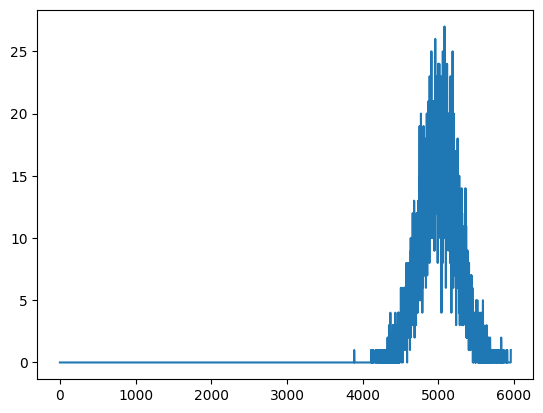

In [18]:
spec6 = Spectrum.from_listmode(lmd)
print("nbins =", len(spec6))
print("Uniform bins?", spec6.has_uniform_bins())
plt.plot(spec6.counts_vals)
plt.show()

Or we can specify bins and ranges ourselves

nbins = 1000
Uniform bins? True


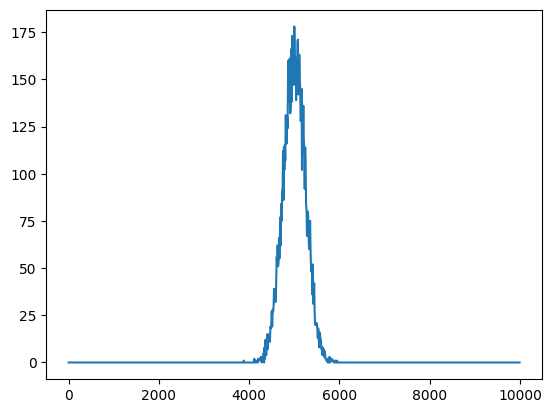

In [19]:
spec7 = Spectrum.from_listmode(lmd, bins=1000, xmin=0, xmax=10000)
print("nbins =", len(spec7))
print("Uniform bins?", spec7.has_uniform_bins())
plt.plot(spec7.bin_edges_raw[:-1], spec7.counts_vals)
plt.show()
# Note that the Spectrum.plot() method fails here because it works in bin mode.
# There might be a kwargs solution to that problem, but it should be fixed later.

We can even specify an array of (possibly non-uniform) bins

nbins = 119
Uniform bins? False
[15.43616208 15.49601408 15.55609815 15.61641519 15.6769661  15.73775179
 15.79877317 15.86003115 15.92152666 15.9832606  16.04523391 16.10744752
 16.16990235 16.23259935 16.29553945 16.35872358 16.42215271 16.48582778
 16.54974974 16.61391955 16.67833818 16.74300657 16.80792572 16.87309658
 16.93852013 17.00419735 17.07012924 17.13631676 17.20276092 17.26946271
 17.33642313 17.40364318 17.47112386 17.5388662  17.6068712  17.67513988
 17.74367327 17.81247238 17.88153826 17.95087194 18.02047444 18.09034682
 18.16049013 18.23090541 18.30159371 18.3725561  18.44379364 18.5153074
 18.58709844 18.65916784 18.73151669 18.80414606 18.87705704 18.95025072
 19.02372821 19.0974906  19.17153899 19.2458745  19.32049823 19.39541131
 19.47061486 19.54611    19.62189786 19.69797959 19.77435631 19.85102917
 19.92799933 20.00526792 20.08283612 20.16070508 20.23887597 20.31734996
 20.39612822 20.47521193 20.55460229 20.63430047 20.71430767 20.79462509
 20.87525393 20.9561

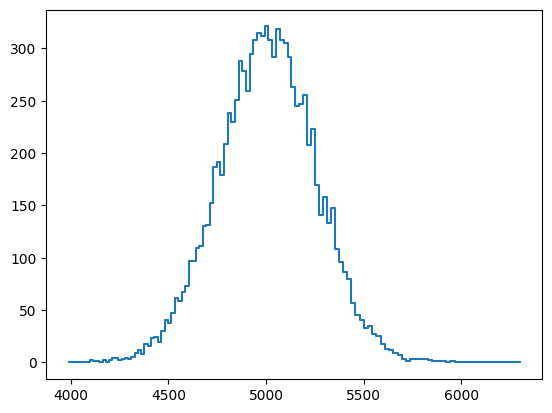

In [20]:
logbins = np.logspace(3.6, 3.8, num=120)
spec8 = Spectrum.from_listmode(lmd, bins=logbins)
print("nbins =", len(spec8))
print("Uniform bins?", spec8.has_uniform_bins())
print(spec8.bin_widths_raw)
plt.step(spec8.bin_centers_raw, spec8.counts_vals)
plt.show()

Find the bins corresponding to a particular channel(s)

In [21]:
print(spec7.find_bin_index(3996))
print(spec7.find_bin_index(0))
print(spec7.find_bin_index(9999))
print(spec7.find_bin_index(np.array([4000, 5000, 6000])))
print(spec8.find_bin_index(np.array([4000, 5000, 6000])))

399
0
999
[400 500 600]
[  1  58 105]


In [22]:
# test that the bin up edge is out-of-range
try:
    print(spec7.find_bin_index(10000))
except SpectrumError:
    print("Failed successfully!")

Failed successfully!


In [23]:
print(spec8.find_bin_index(3996))
print(spec8.bin_edges_raw[0])
print(spec8.bin_edges_raw[1])

0
3981.0717055349733
3996.5078676179


Read in from a list-mode h5

In [24]:
lmd = tables.open_file("../tests/samples/misc/cllbc_listmode.h5", "r").root.Energy
spec9 = Spectrum.from_listmode(lmd, bins=500, xmin=0, xmax=1000000)

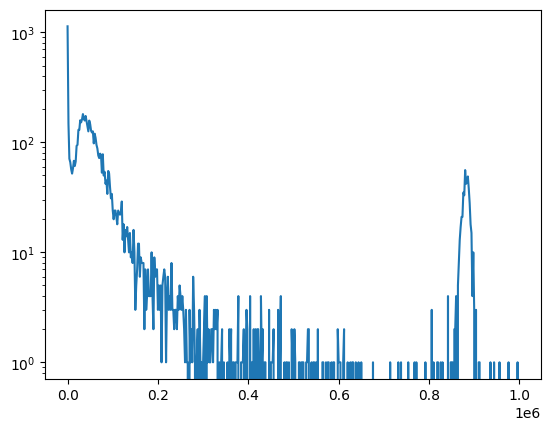

In [25]:
plt.figure()
plt.plot(spec9.bin_edges_raw[:-1], spec9.counts_vals)
plt.yscale("log")
plt.show()

Timestamps can be passed to the Spectrum constructor through **kwargs and/or through setting members manually

nbins = 1000
mean wait time = 0:00:00.996260
start = 1969-07-20 02:56:00.563834
stop  = 1969-07-20 05:42:02.170162
real  = 2:46:01.606328
live  = 2:44:21.990265


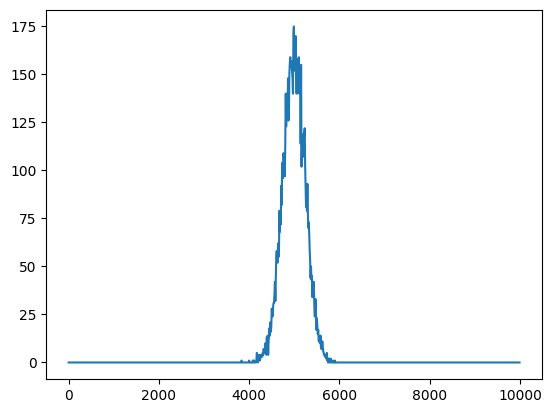

In [26]:
nsamples = 10000
lmd = np.random.normal(5000, 250, nsamples)
times = np.cumsum(np.random.exponential(1.0 / 86400.0, nsamples))
start = datetime.datetime(1969, 7, 20, 2, 56)
times = [start + datetime.timedelta(t) for t in times]
spec10 = Spectrum.from_listmode(
    lmd, bins=1000, xmin=0, xmax=10000, start_time=min(times), stop_time=max(times)
)  # through **kwargs
spec10.real_time = spec10.stop_time - spec10.start_time  # or manually
spec10.live_time = 0.99 * spec10.real_time

print("nbins =", len(spec10))
print(
    "mean wait time =", np.mean(np.diff(times))
)  # in days, if not formatted via datetime
print("start =", spec10.start_time)
print("stop  =", spec10.stop_time)
print("real  =", spec10.real_time)
print("live  =", spec10.live_time)
plt.plot(spec10.bin_edges_raw[:-1], spec10.counts_vals)
plt.show()